In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from matplotlib import rcParams
# from jupyterthemes import jtplot
# jtplot.reset()

rcParams['figure.figsize'] = [12, 8]

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
batch_size = 32

learning_rate = 1e-3
num_epochs = 10

In [6]:
train_dataset = datasets.MNIST('./datas/mnist', train=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./datas/mnist', train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

\begin{equation}
H_{out} = (H_{in} - 1) * \text{stride}[0] - 2 * \text{padding}[0]
      + \text{kernel_size}[0] + \text{output_padding}[0]\\W_{out} = (W_{in} - 1) * \text{stride}[1] - 2 * \text{padding}[1]
      + \text{kernel_size}[1] + \text{output_padding}[1]
\end{equation}

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, inp_dim, out_dim): # 784 784
        super(Autoencoder, self).__init__()
        
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        ) # b 64 14 14
        
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        ) # b 32 7 7
        
        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        ) # b 16 3 3
        
        self.encoder_fc = nn.Sequential(
            nn.Linear(144, 2)
        )
        
        self.decoder_fc = nn.Sequential(
            nn.Linear(2, 32)
        ) # b 8 2 2
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        ) # b 1 28 28
        
    def forward(self, x):
        outs = self.encoder_conv1(x)
        outs = self.encoder_conv2(outs)
        outs = self.encoder_conv3(outs)
        outs = outs.view(-1, 144)
        encoder = self.encoder_fc(outs)
        
        outs = self.decoder_fc(encoder)
        outs = outs.view(-1, 8, 2, 2)
        outs = self.decoder(outs)
        return outs, encoder
        
        
        

In [8]:
model = Autoencoder(28 * 28, 28 * 28).to(device)

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
train_data_count = len(train_dataset)
for epoch in range(num_epochs):
    
    running_loss = .0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        
        outputs, encoders = model(images)
        
        loss = criterion(outputs, images)
        
        running_loss += loss.item() * images.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 500 == 0:
            print "Epoch: [{}/{}], Step [{}/{}], loss: {:.6f}".format(epoch+1, num_epochs, \
                                                                      (i+1)*images.size(0), train_data_count, \
                                                                      running_loss / (images.size(0) * i))
        
    print "Finish Epoch: [{}/{}]: loss: {:.6f}".format(epoch+1, num_epochs, running_loss / len(train_dataset))
        

Epoch: [1/10], Step [16000/60000], loss: 0.061954
Epoch: [1/10], Step [32000/60000], loss: 0.059059
Epoch: [1/10], Step [48000/60000], loss: 0.057709
Finish Epoch: [1/10]: loss: 0.057110
Epoch: [2/10], Step [16000/60000], loss: 0.054356
Epoch: [2/10], Step [32000/60000], loss: 0.054067
Epoch: [2/10], Step [48000/60000], loss: 0.053829
Finish Epoch: [2/10]: loss: 0.053595
Epoch: [3/10], Step [16000/60000], loss: 0.052663
Epoch: [3/10], Step [32000/60000], loss: 0.052404
Epoch: [3/10], Step [48000/60000], loss: 0.052167
Finish Epoch: [3/10]: loss: 0.052018
Epoch: [4/10], Step [16000/60000], loss: 0.051121
Epoch: [4/10], Step [32000/60000], loss: 0.051086
Epoch: [4/10], Step [48000/60000], loss: 0.050896
Finish Epoch: [4/10]: loss: 0.050738
Epoch: [5/10], Step [16000/60000], loss: 0.050340
Epoch: [5/10], Step [32000/60000], loss: 0.050123
Epoch: [5/10], Step [48000/60000], loss: 0.049894
Finish Epoch: [5/10]: loss: 0.049822
Epoch: [6/10], Step [16000/60000], loss: 0.049681
Epoch: [6/10], 

In [10]:
all_encoder = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs, encoders = model(images)
        all_encoder.append([encoders.cpu().data.numpy(), labels.data.numpy()])
    
all_encoder = np.asarray(all_encoder)

In [11]:
encoders = np.concatenate((np.vstack(all_encoder[:,0]), np.hstack(all_encoder[:, 1]).reshape((10000, -1))), axis=1)

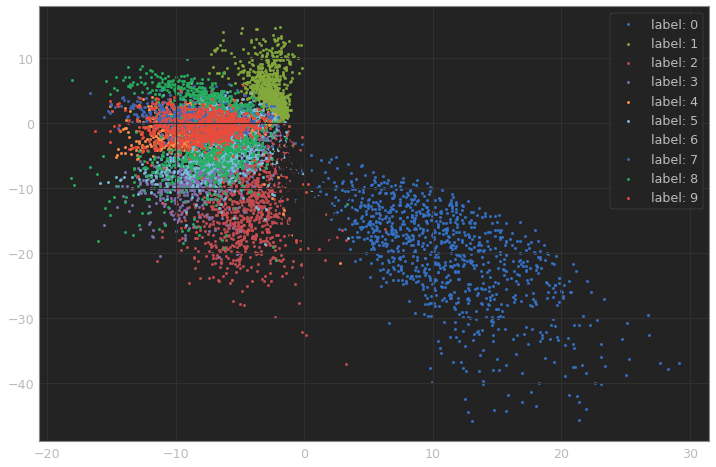

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(10):
    enc = encoders[encoders[:,2] == i]
    ax.scatter(enc[:,0], enc[:,1], label='label: {}'.format(i), marker='.')
    
plt.legend()
plt.show()